# Tree Canopy Percentage, Green Space, and Air Quality Correlation to COPD in Ohio cities (2016 Data) (Part 1)
1. EDA
2. Analysis 
3. Testing
4. Models

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pickle
import seaborn as sns
%matplotlib inline
import string
import collections

from pandas.plotting import register_matplotlib_converters
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text

## Importing Datasets

### Part 1: AQI values
I. Cincinnati, OH-KY-IN

To accurately describe changes in air quality for locations and time periods with biases in the monitoring network, we apply rolling window regression. This recursively calculates the change in pollutant concentration as a function of time, which can be used as a proxy for the true trend. This also more accurately reflects the true trend than averaging the time series. It can smooth random short-term variations. We will use simple moving average (SMA), cumulative moving average (CMA), exponential moving average, and estimating trends in NO2, CO, Ozone.

Reference: https://www.sciencedirect.com/science/article/pii/S2590162119300334 

In [2]:
df_CO = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cinci10_co.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [3]:
df_CO.head() #check table

Carbon_Monoxide_AQI_Value    Site Name      Site ID Source
Date                                                                  
2010-01-01                          2  POST OFFICE  39-061-0021    AQS
2010-01-02                          3  POST OFFICE  39-061-0021    AQS
2010-01-03                          3  POST OFFICE  39-061-0021    AQS
2010-01-04                          5  POST OFFICE  39-061-0021    AQS
2010-01-05                          5  POST OFFICE  39-061-0021    AQS

In [4]:
df_CO.info() #look at dtypes

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3843 entries, 2010-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Carbon_Monoxide_AQI_Value  3843 non-null   int64 
 1   Site Name                  3843 non-null   object
 2   Site ID                    3843 non-null   object
 3   Source                     3843 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.1+ KB


In [5]:
df_CO.isnull().sum() #count number of missing values

Carbon_Monoxide_AQI_Value    0
Site Name                    0
Site ID                      0
Source                       0
dtype: int64

In [6]:
# calculate the yearly average CO AQI 
df_CO['Carbon_Monoxide_AQI_Value'] = df_CO.mean(axis=1)

# drop columns containing monthly values
df_CO = df_CO[['Carbon_Monoxide_AQI_Value']]

# visualize the first 5 columns
df_CO.head()

Carbon_Monoxide_AQI_Value
Date                                 
2010-01-01                        2.0
2010-01-02                        3.0
2010-01-03                        3.0
2010-01-04                        5.0
2010-01-05                        5.0

Text(0, 0.5, 'CO AQI Value')

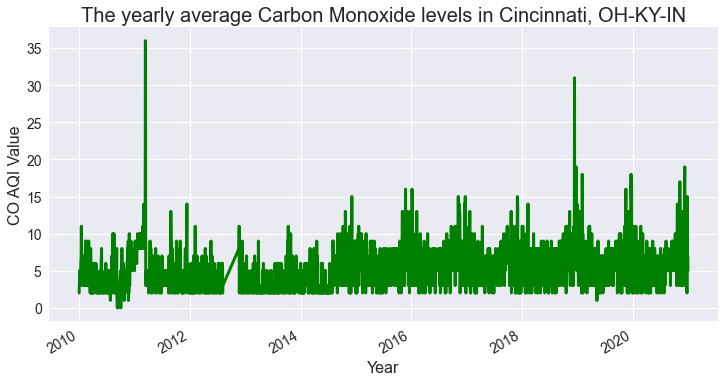

In [7]:
plt.style.use('seaborn')

# line plot - the yearly average CO AQI in Cinicinnati OH-KY-IN
df_CO.plot(color='green', linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')

# title and labels
plt.title('The yearly average Carbon Monoxide levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO AQI Value', fontsize=16)

In [8]:
# the simple moving average over a period of 10 years
df_CO['SMA_10'] = df_CO.Carbon_Monoxide_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df_CO['SMA_20'] = df_CO.Carbon_Monoxide_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'CO AQI Value')

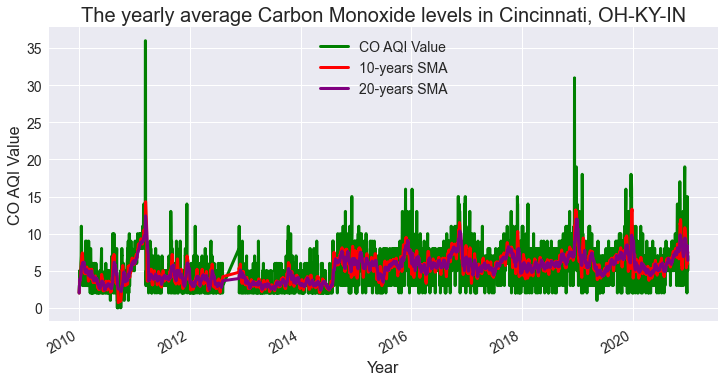

In [9]:
# colors for the line plot
colors = ['green', 'red', 'purple']

# line plot - the yearly average air temperature in Barcelona
df_CO.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['CO AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average Carbon Monoxide levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO AQI Value', fontsize=16)

In [10]:
# cumulative moving average
df_CO['CMA'] = df_CO.Carbon_Monoxide_AQI_Value.expanding().mean()

Text(0, 0.5, 'CO AQI Value')

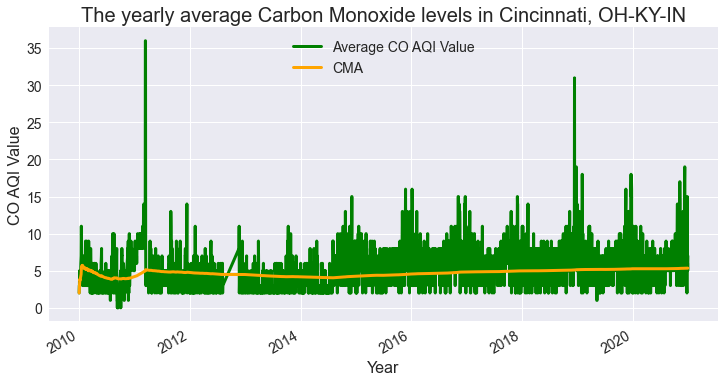

In [11]:
# colors for the line plot
colors = ['green', 'orange']

# line plot - the yearly average air temperature in Barcelona
df_CO[['Carbon_Monoxide_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average CO AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average Carbon Monoxide levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO AQI Value', fontsize=16)

In [12]:
df_oz = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cinci10_oz.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [13]:
df_oz.head()

Ozone_AQI_Value Site Name      Site ID Source
Date                                                     
2010-01-01               26    Oxford  39-017-9991    AQS
2010-01-02               30    Oxford  39-017-9991    AQS
2010-01-03               28    Oxford  39-017-9991    AQS
2010-01-04               24    Oxford  39-017-9991    AQS
2010-01-05               20    Oxford  39-017-9991    AQS

In [14]:
df_oz.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4015 entries, 2010-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ozone_AQI_Value  4015 non-null   int64 
 1   Site Name        4015 non-null   object
 2   Site ID          4015 non-null   object
 3   Source           4015 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.8+ KB


In [15]:
df_oz.isnull().sum()

Ozone_AQI_Value    0
Site Name          0
Site ID            0
Source             0
dtype: int64

In [16]:
# calculate the yearly average CO AQI 
df_oz['Ozone_AQI_Value'] = df_oz.mean(axis=1)

# drop columns containing monthly values
df_oz = df_oz[['Ozone_AQI_Value']]

# visualize the first 5 columns
df_oz.head()

Ozone_AQI_Value
Date                       
2010-01-01             26.0
2010-01-02             30.0
2010-01-03             28.0
2010-01-04             24.0
2010-01-05             20.0

Text(0, 0.5, 'Ozone AQI Value')

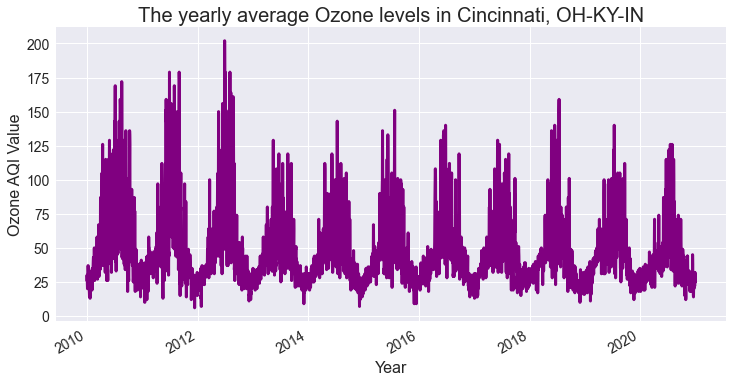

In [17]:
plt.style.use('seaborn')

# line plot - the yearly average CO AQI in Cinicinnati OH-KY-IN
df_oz.plot(color='purple', linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')

# title and labels
plt.title('The yearly average Ozone levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone AQI Value', fontsize=16)

In [18]:
# the simple moving average over a period of 10 years
df_oz['SMA_10'] = df_oz.Ozone_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df_oz['SMA_20'] = df_oz.Ozone_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'Ozone AQI Value')

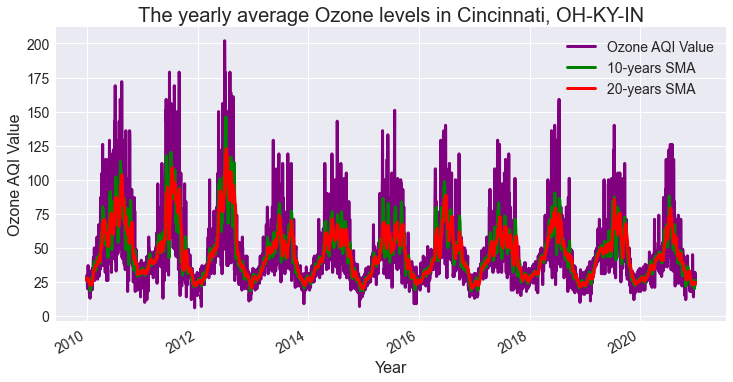

In [19]:
# colors for the line plot
colors = ['purple', 'green', 'red']

# line plot - the yearly average air temperature in Barcelona
df_oz.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Ozone AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average Ozone levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone AQI Value', fontsize=16)

In [20]:
# cumulative moving average
df_oz['CMA'] = df_oz.Ozone_AQI_Value.expanding().mean()

Text(0, 0.5, 'Ozone AQI Value')

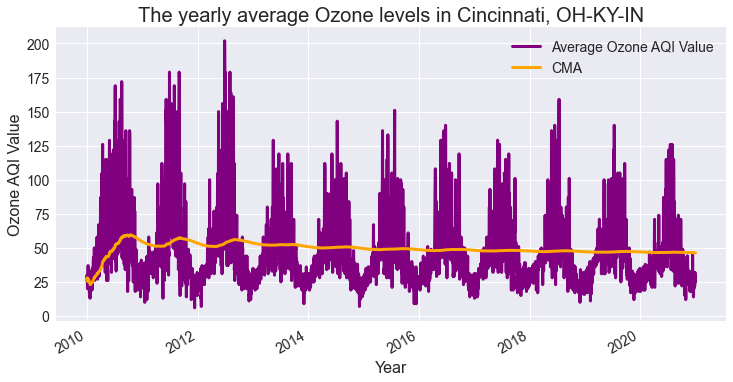

In [21]:
# colors for the line plot
colors = ['purple', 'orange']

# line plot - the yearly average air temperature in Barcelona
df_oz[['Ozone_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average Ozone AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average Ozone levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone AQI Value', fontsize=16)

In [22]:
df_no2 = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cinci10_no2.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [23]:
df_no2.head()

Nitrogen_Dioxide_AQI_Value                           Site Name  \
Date                                                                         
2010-01-01                           9                          Taft NCore   
2010-01-02                          10                          Taft NCore   
2010-01-03                           8  NORTHERN KENTUCKY UNIVERSITY (NKU)   
2010-01-04                          15                          Taft NCore   
2010-01-05                          19                          Taft NCore   

                Site ID Source  
Date                            
2010-01-01  39-061-0040    AQS  
2010-01-02  39-061-0040    AQS  
2010-01-03  21-037-3002    AQS  
2010-01-04  39-061-0040    AQS  
2010-01-05  39-061-0040    AQS

In [24]:
df_no2.isnull().sum()

Nitrogen_Dioxide_AQI_Value    0
Site Name                     0
Site ID                       0
Source                        0
dtype: int64

In [25]:
# calculate the yearly average CO AQI 
df_no2['Nitrogen_Dioxide_AQI_Value'] = df_no2.mean(axis=1)

# drop columns containing monthly values
df_no2 = df_no2[['Nitrogen_Dioxide_AQI_Value']]

# visualize the first 5 columns
df_no2.head()

Nitrogen_Dioxide_AQI_Value
Date                                  
2010-01-01                         9.0
2010-01-02                        10.0
2010-01-03                         8.0
2010-01-04                        15.0
2010-01-05                        19.0

In [26]:
# cumulative moving average
df_no2['CMA'] = df_no2.Nitrogen_Dioxide_AQI_Value.expanding().mean()

Text(0, 0.5, 'NO2 AQI Value')

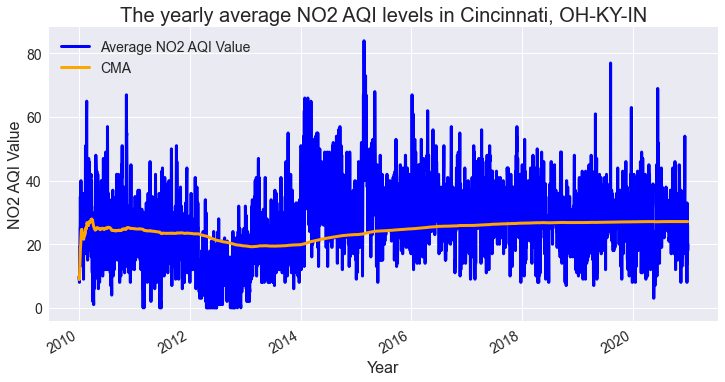

In [27]:
# colors for the line plot
colors = ['blue', 'orange']

# line plot - the yearly average air temperature in Barcelona
df_no2[['Nitrogen_Dioxide_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average NO2 AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average NO2 AQI levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('NO2 AQI Value', fontsize=16)

In [28]:
# the simple moving average over a period of 10 years
df_no2['SMA_10'] = df_no2.Nitrogen_Dioxide_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df_no2['SMA_20'] = df_no2.Nitrogen_Dioxide_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'NO2 AQI Value')

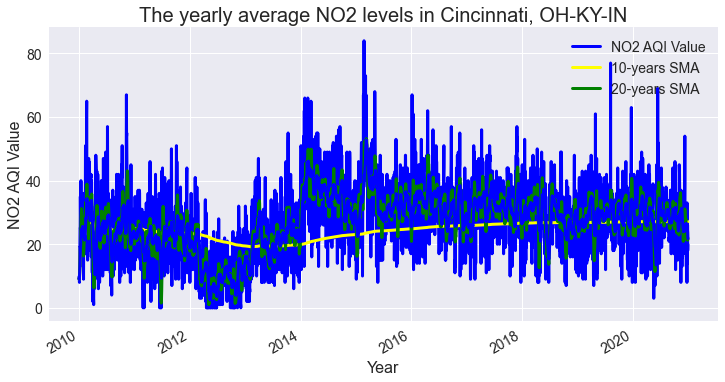

In [29]:
# colors for the line plot
colors = ['blue', 'yellow', 'green']

# line plot - the yearly average air temperature in Barcelona
df_no2.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['NO2 AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average NO2 levels in Cincinnati, OH-KY-IN', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('NO2 AQI Value', fontsize=16)

Takeaway: Ozone levels in Cincinnati OH-KY-IN region have their spikes during summer months from 2010-2020, and there is a downward trend (evidence for ozone depletion). CO levels are steady (although we have to ask ourselves why there was a huge spike around 01/2019). Interestingly, NO2 levels decreased from 2012 to 2013, but went back up in 2014 and has been flatline through 2020. 

II. Cleveland-Elyria, OH

In [30]:
df2_co = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cle10y_co.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [31]:
df2_co.head()

Carbon_Monoxide_AQI_Value       Site Name      Site ID Source
Date                                                                     
2010-01-01                          5  CORLETT SCHOOL  39-035-0070    AQS
2010-01-02                          5          Mentor  39-085-0006    AQS
2010-01-03                          6  CORLETT SCHOOL  39-035-0070    AQS
2010-01-04                          6  CORLETT SCHOOL  39-035-0070    AQS
2010-01-05                          6  CORLETT SCHOOL  39-035-0070    AQS

In [32]:
df2_co.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2010-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Carbon_Monoxide_AQI_Value  4018 non-null   int64 
 1   Site Name                  4018 non-null   object
 2   Site ID                    4018 non-null   object
 3   Source                     4018 non-null   object
dtypes: int64(1), object(3)
memory usage: 157.0+ KB


In [33]:
df2_co.isnull().sum()

Carbon_Monoxide_AQI_Value    0
Site Name                    0
Site ID                      0
Source                       0
dtype: int64

In [34]:
# calculate the yearly average CO AQI 
df2_co['Carbon_Monoxide_AQI_Value'] = df2_co.mean(axis=1)

# drop columns containing monthly values
df2_co = df2_co[['Carbon_Monoxide_AQI_Value']]

# visualize the first 5 columns
df2_co.head()

Carbon_Monoxide_AQI_Value
Date                                 
2010-01-01                        5.0
2010-01-02                        5.0
2010-01-03                        6.0
2010-01-04                        6.0
2010-01-05                        6.0

In [35]:
# the simple moving average over a period of 10 years
df2_co['SMA_10'] = df2_co.Carbon_Monoxide_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df2_co['SMA_20'] = df2_co.Carbon_Monoxide_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'CO AQI Value')

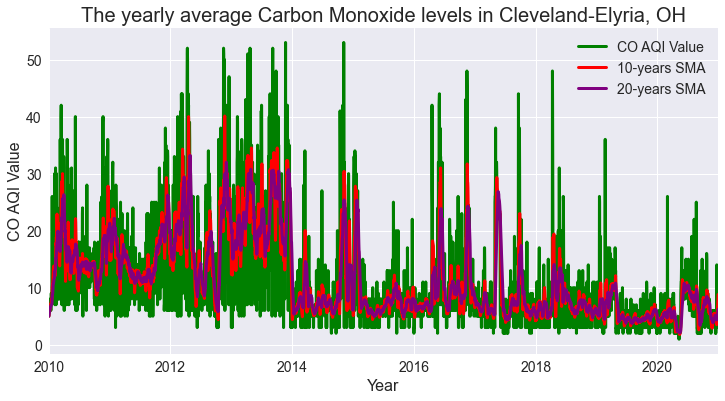

In [36]:
# colors for the line plot
colors = ['green', 'red', 'purple']

# line plot - the yearly average air temperature in Barcelona
df2_co.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['CO AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average Carbon Monoxide levels in Cleveland-Elyria, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO AQI Value', fontsize=16)

In [37]:
# cumulative moving average
df2_co['CMA'] = df2_co.Carbon_Monoxide_AQI_Value.expanding().mean()

Text(0, 0.5, 'CO AQI Value')

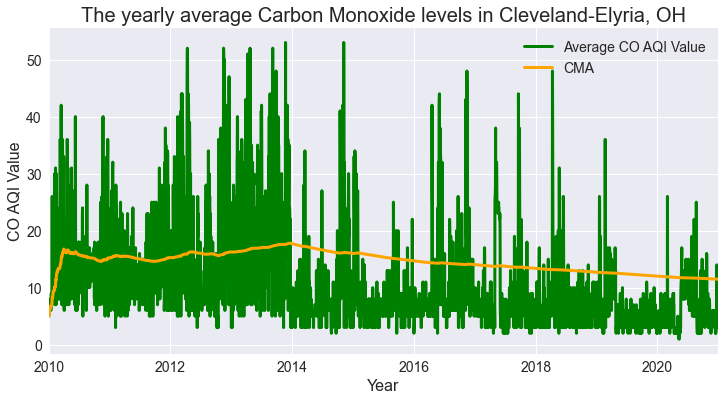

In [38]:
# colors for the line plot
colors = ['green', 'orange']

# line plot - the yearly average air temperature in Barcelona
df2_co[['Carbon_Monoxide_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average CO AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average Carbon Monoxide levels in Cleveland-Elyria, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO AQI Value', fontsize=16)

In [39]:
df2_oz = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cle10y_oz.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [40]:
df2_oz.head()

Ozone_AQI_Value       Site Name      Site ID Source
Date                                                           
2010-01-01               31  GT Craig NCore  39-035-0060    AQS
2010-01-02               25  GT Craig NCore  39-035-0060    AQS
2010-01-03               24  GT Craig NCore  39-035-0060    AQS
2010-01-04               24  GT Craig NCore  39-035-0060    AQS
2010-01-05               22  GT Craig NCore  39-035-0060    AQS

In [41]:
df2_oz.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3994 entries, 2010-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ozone_AQI_Value  3994 non-null   int64 
 1   Site Name        3994 non-null   object
 2   Site ID          3994 non-null   object
 3   Source           3994 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.0+ KB


In [42]:
df2_oz.isnull().sum()

Ozone_AQI_Value    0
Site Name          0
Site ID            0
Source             0
dtype: int64

In [43]:
# calculate the yearly average CO AQI 
df2_oz['Ozone_AQI_Value'] = df2_oz.mean(axis=1)

# drop columns containing monthly values
df2_oz = df2_oz[['Ozone_AQI_Value']]

# visualize the first 5 columns
df2_oz.head()

Ozone_AQI_Value
Date                       
2010-01-01             31.0
2010-01-02             25.0
2010-01-03             24.0
2010-01-04             24.0
2010-01-05             22.0

In [44]:
# the simple moving average over a period of 10 years
df2_oz['SMA_10'] = df2_oz.Ozone_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df2_oz['SMA_20'] = df2_oz.Ozone_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'Ozone AQI Value')

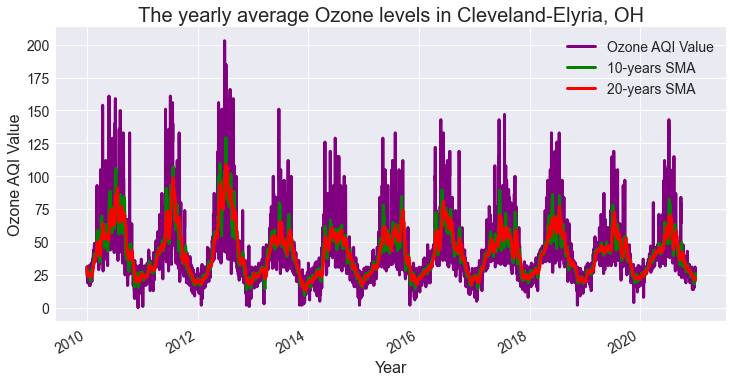

In [45]:
# colors for the line plot
colors = ['purple', 'green', 'red']

# line plot - the yearly average air temperature in Barcelona
df2_oz.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Ozone AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average Ozone levels in Cleveland-Elyria, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone AQI Value', fontsize=16)

In [46]:
# cumulative moving average
df2_oz['CMA'] = df2_oz.Ozone_AQI_Value.expanding().mean()

Text(0, 0.5, 'Ozone AQI Value')

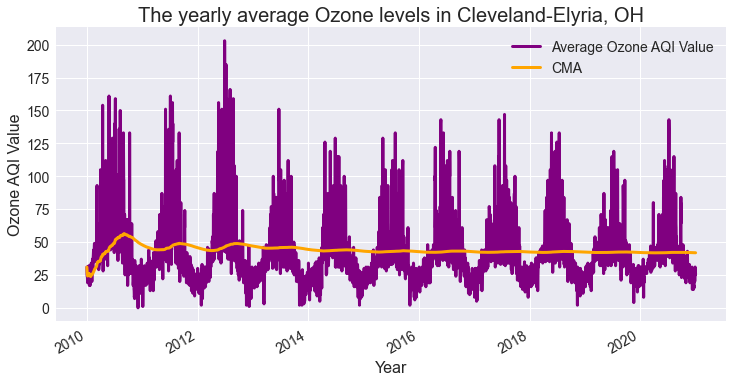

In [47]:
# colors for the line plot
colors = ['purple', 'orange']

# line plot - the yearly average air temperature in Barcelona
df2_oz[['Ozone_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average Ozone AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average Ozone levels in Cleveland-Elyria, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone AQI Value', fontsize=16)

In [48]:
df2_no2 = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cle10y_no2.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [49]:
df2_no2.head()

Nitrogen_Dioxide_AQI_Value       Site Name      Site ID Source
Date                                                                      
2010-01-01                          19  GT Craig NCore  39-035-0060    AQS
2010-01-02                          17  GT Craig NCore  39-035-0060    AQS
2010-01-03                          19  GT Craig NCore  39-035-0060    AQS
2010-01-04                          24  GT Craig NCore  39-035-0060    AQS
2010-01-05                          26  GT Craig NCore  39-035-0060    AQS

In [50]:
df2_no2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2010-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Nitrogen_Dioxide_AQI_Value  3950 non-null   int64 
 1   Site Name                   3950 non-null   object
 2   Site ID                     3950 non-null   object
 3   Source                      3950 non-null   object
dtypes: int64(1), object(3)
memory usage: 154.3+ KB


In [51]:
df2_no2.isnull().sum()

Nitrogen_Dioxide_AQI_Value    0
Site Name                     0
Site ID                       0
Source                        0
dtype: int64

In [52]:
# calculate the yearly average CO AQI 
df2_no2['Nitrogen_Dioxide_AQI_Value'] = df2_no2.mean(axis=1)

# drop columns containing monthly values
df2_no2 = df2_no2[['Nitrogen_Dioxide_AQI_Value']]

# visualize the first 5 columns
df2_no2.head()

Nitrogen_Dioxide_AQI_Value
Date                                  
2010-01-01                        19.0
2010-01-02                        17.0
2010-01-03                        19.0
2010-01-04                        24.0
2010-01-05                        26.0

In [53]:
# the simple moving average over a period of 10 years
df2_no2['SMA_10'] = df2_no2.Nitrogen_Dioxide_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df2_no2['SMA_20'] = df2_no2.Nitrogen_Dioxide_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'NO2 AQI Value')

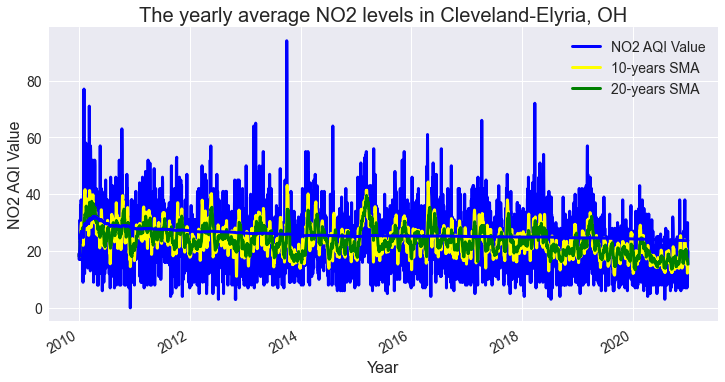

In [57]:
# colors for the line plot
colors = ['blue', 'yellow', 'green']

# line plot - the yearly average air temperature in Barcelona
df2_no2.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['NO2 AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average NO2 levels in Cleveland-Elyria, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('NO2 AQI Value', fontsize=16)

In [58]:
# cumulative moving average
df2_no2['CMA'] = df2_no2.Nitrogen_Dioxide_AQI_Value.expanding().mean()

Text(0, 0.5, 'NO2 AQI Value')

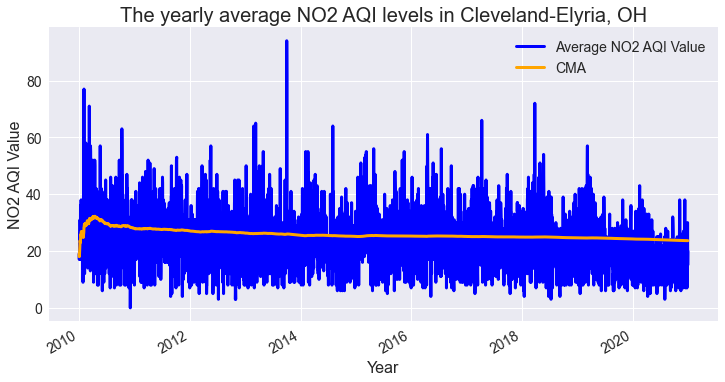

In [59]:
# colors for the line plot
colors = ['blue', 'orange']

# line plot - the yearly average air temperature in Barcelona
df2_no2[['Nitrogen_Dioxide_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average NO2 AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average NO2 AQI levels in Cleveland-Elyria, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('NO2 AQI Value', fontsize=16)

IIi. Columbus, OH

In [60]:
df3_co = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_col10y_co.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [61]:
df3_co.head()

Carbon_Monoxide_AQI_Value Site Name      Site ID Source
Date                                                               
2010-01-01                          3  Morse Rd  39-049-0005    AQS
2010-01-02                          5  Morse Rd  39-049-0005    AQS
2010-01-03                          5  Morse Rd  39-049-0005    AQS
2010-01-04                          6  Morse Rd  39-049-0005    AQS
2010-01-05                          5  Morse Rd  39-049-0005    AQS

In [62]:
df3_co.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4007 entries, 2010-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Carbon_Monoxide_AQI_Value  4007 non-null   int64 
 1   Site Name                  4007 non-null   object
 2   Site ID                    4007 non-null   object
 3   Source                     4007 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.5+ KB


In [63]:
df3_co.isnull().sum()

Carbon_Monoxide_AQI_Value    0
Site Name                    0
Site ID                      0
Source                       0
dtype: int64

In [64]:
# calculate the yearly average CO AQI 
df3_co['Carbon_Monoxide_AQI_Value'] = df3_co.mean(axis=1)

# drop columns containing monthly values
df3_co = df3_co[['Carbon_Monoxide_AQI_Value']]

# visualize the first 5 columns
df3_co.head()

Carbon_Monoxide_AQI_Value
Date                                 
2010-01-01                        3.0
2010-01-02                        5.0
2010-01-03                        5.0
2010-01-04                        6.0
2010-01-05                        5.0

In [65]:
# the simple moving average over a period of 10 years
df3_co['SMA_10'] = df3_co.Carbon_Monoxide_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df3_co['SMA_20'] = df3_co.Carbon_Monoxide_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'CO AQI Value')

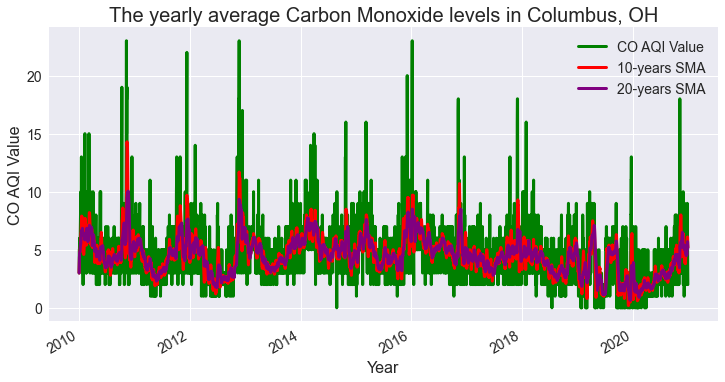

In [66]:
# colors for the line plot
colors = ['green', 'red', 'purple']

# line plot - the yearly average air temperature in Barcelona
df3_co.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['CO AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average Carbon Monoxide levels in Columbus, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO AQI Value', fontsize=16)

In [67]:
# cumulative moving average
df3_co['CMA'] = df2_co.Carbon_Monoxide_AQI_Value.expanding().mean()

Text(0, 0.5, 'CO AQI Value')

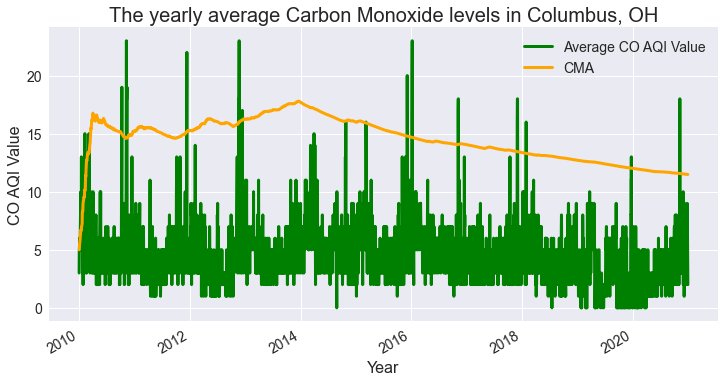

In [68]:
# colors for the line plot
colors = ['green', 'orange']

# line plot - the yearly average air temperature in Barcelona
df3_co[['Carbon_Monoxide_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average CO AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average Carbon Monoxide levels in Columbus, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO AQI Value', fontsize=16)

In [69]:
df3_no2 = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_col10y_no2.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [70]:
df3_no2.head()

Nitrogen_Dioxide_AQI_Value    Site Name      Site ID Source
Date                                                                   
2013-04-01                           8  FRANKLIN_PK  39-049-0037    AQS
2013-04-02                          20  FRANKLIN_PK  39-049-0037    AQS
2013-04-03                          33  FRANKLIN_PK  39-049-0037    AQS
2013-04-04                          40  FRANKLIN_PK  39-049-0037    AQS
2013-04-05                          37  FRANKLIN_PK  39-049-0037    AQS

In [71]:
df3_no2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2830 entries, 2013-04-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Nitrogen_Dioxide_AQI_Value  2830 non-null   int64 
 1   Site Name                   2830 non-null   object
 2   Site ID                     2830 non-null   object
 3   Source                      2830 non-null   object
dtypes: int64(1), object(3)
memory usage: 110.5+ KB


In [72]:
df3_no2.isnull().sum()

Nitrogen_Dioxide_AQI_Value    0
Site Name                     0
Site ID                       0
Source                        0
dtype: int64

In [73]:
# calculate the yearly average CO AQI 
df3_no2['Nitrogen_Dioxide_AQI_Value'] = df3_no2.mean(axis=1)

# drop columns containing monthly values
df3_no2 = df2_no2[['Nitrogen_Dioxide_AQI_Value']]

# visualize the first 5 columns
df3_no2.head()

Nitrogen_Dioxide_AQI_Value
Date                                  
2010-01-01                        19.0
2010-01-02                        17.0
2010-01-03                        19.0
2010-01-04                        24.0
2010-01-05                        26.0

In [74]:
# the simple moving average over a period of 10 years
df3_no2['SMA_10'] = df3_no2.Nitrogen_Dioxide_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df3_no2['SMA_20'] = df3_no2.Nitrogen_Dioxide_AQI_Value.rolling(20, min_periods=1).mean()

<ipython-input-74-7531685b6a47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_no2['SMA_10'] = df3_no2.Nitrogen_Dioxide_AQI_Value.rolling(10, min_periods=1).mean()
<ipython-input-74-7531685b6a47>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_no2['SMA_20'] = df3_no2.Nitrogen_Dioxide_AQI_Value.rolling(20, min_periods=1).mean()


Text(0, 0.5, 'NO2 AQI Value')

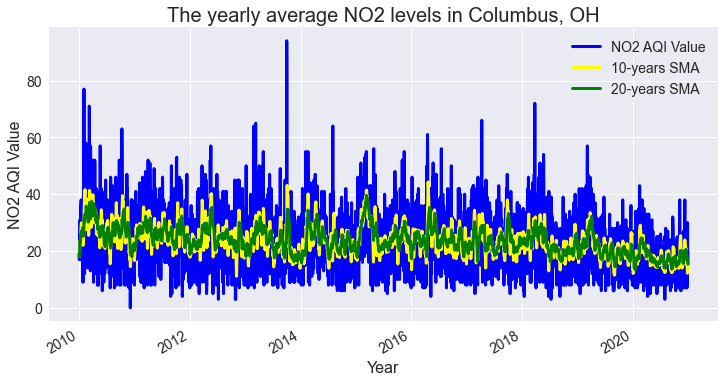

In [75]:
# colors for the line plot
colors = ['blue', 'yellow', 'green']

# line plot - the yearly average air temperature in Barcelona
df3_no2.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['NO2 AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average NO2 levels in Columbus, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('NO2 AQI Value', fontsize=16)

In [76]:
# cumulative moving average
df3_no2['CMA'] = df3_no2.Nitrogen_Dioxide_AQI_Value.expanding().mean()

Text(0, 0.5, 'NO2 AQI Value')

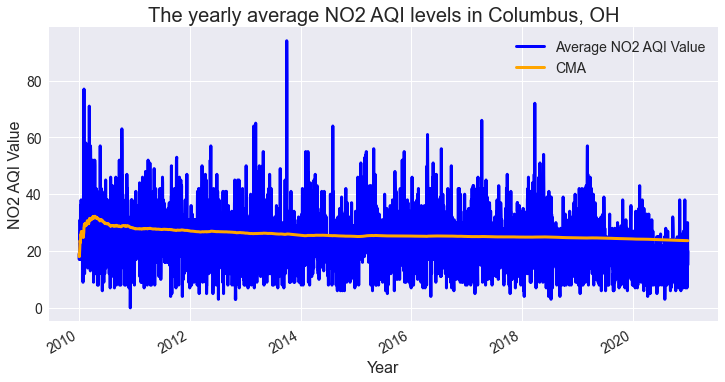

In [77]:
# colors for the line plot
colors = ['blue', 'orange']

# line plot - the yearly average air temperature in Barcelona
df3_no2[['Nitrogen_Dioxide_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average NO2 AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average NO2 AQI levels in Columbus, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('NO2 AQI Value', fontsize=16)

In [78]:
df3_oz = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_col10y_oz.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')

In [79]:
df3_oz.head()

Ozone_AQI_Value   Site Name      Site ID Source
Date                                                       
2010-04-01               80    Delaware  39-041-0002    AQS
2010-04-02              105       Heath  39-089-0005    AQS
2010-04-03               67  New Albany  39-049-0029    AQS
2010-04-04               61    Delaware  39-041-0002    AQS
2010-04-05               54    Delaware  39-041-0002    AQS

In [80]:
df3_oz.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2478 entries, 2010-04-01 to 2020-10-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ozone_AQI_Value  2478 non-null   int64 
 1   Site Name        2478 non-null   object
 2   Site ID          2478 non-null   object
 3   Source           2478 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [81]:
df3_oz.isnull().sum()

Ozone_AQI_Value    0
Site Name          0
Site ID            0
Source             0
dtype: int64

In [82]:
# calculate the yearly average CO AQI 
df3_oz['Ozone_AQI_Value'] = df3_oz.mean(axis=1)

# drop columns containing monthly values
df3_oz = df3_oz[['Ozone_AQI_Value']]

# visualize the first 5 columns
df3_oz.head()

Ozone_AQI_Value
Date                       
2010-04-01             80.0
2010-04-02            105.0
2010-04-03             67.0
2010-04-04             61.0
2010-04-05             54.0

In [83]:
# the simple moving average over a period of 10 years
df3_oz['SMA_10'] = df3_oz.Ozone_AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df3_oz['SMA_20'] = df3_oz.Ozone_AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'Ozone AQI Value')

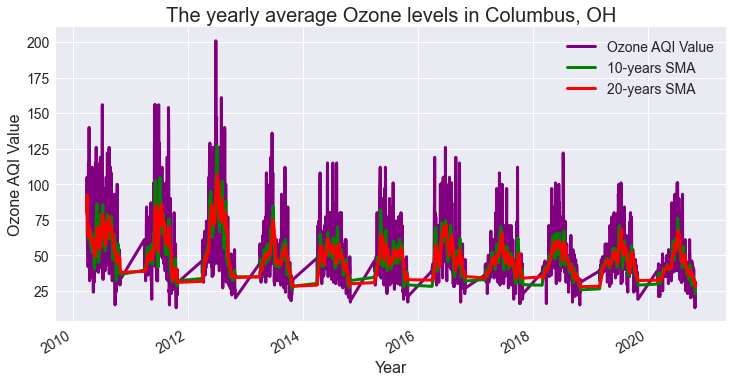

In [84]:
# colors for the line plot
colors = ['purple', 'green', 'red']

# line plot - the yearly average air temperature in Barcelona
df3_oz.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Ozone AQI Value', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average Ozone levels in Columbus, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone AQI Value', fontsize=16)

In [85]:
# cumulative moving average
df3_oz['CMA'] = df3_oz.Ozone_AQI_Value.expanding().mean()

Text(0, 0.5, 'Ozone AQI Value')

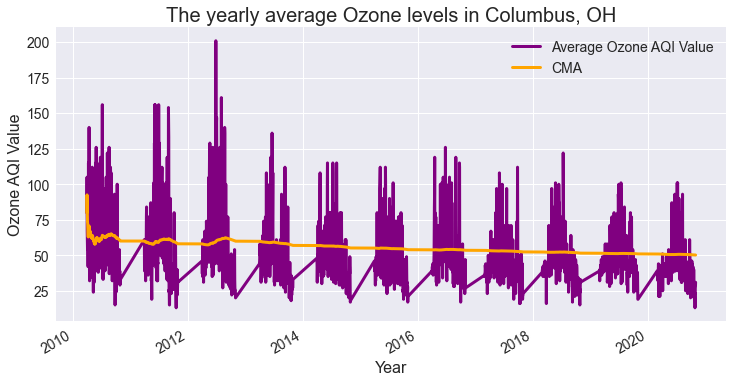

In [86]:
# colors for the line plot
colors = ['purple', 'orange']

# line plot - the yearly average air temperature in Barcelona
df3_oz[['Ozone_AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average Ozone AQI Value', 'CMA'], fontsize=14)

# title and labels
plt.title('The yearly average Ozone levels in Columbus, OH', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone AQI Value', fontsize=16)

### Part 2: Tree Canopy Percentage
Source: https://gis.cuyahogacounty.us/Html5Viewer/?viewer=ccpcgreenprint 

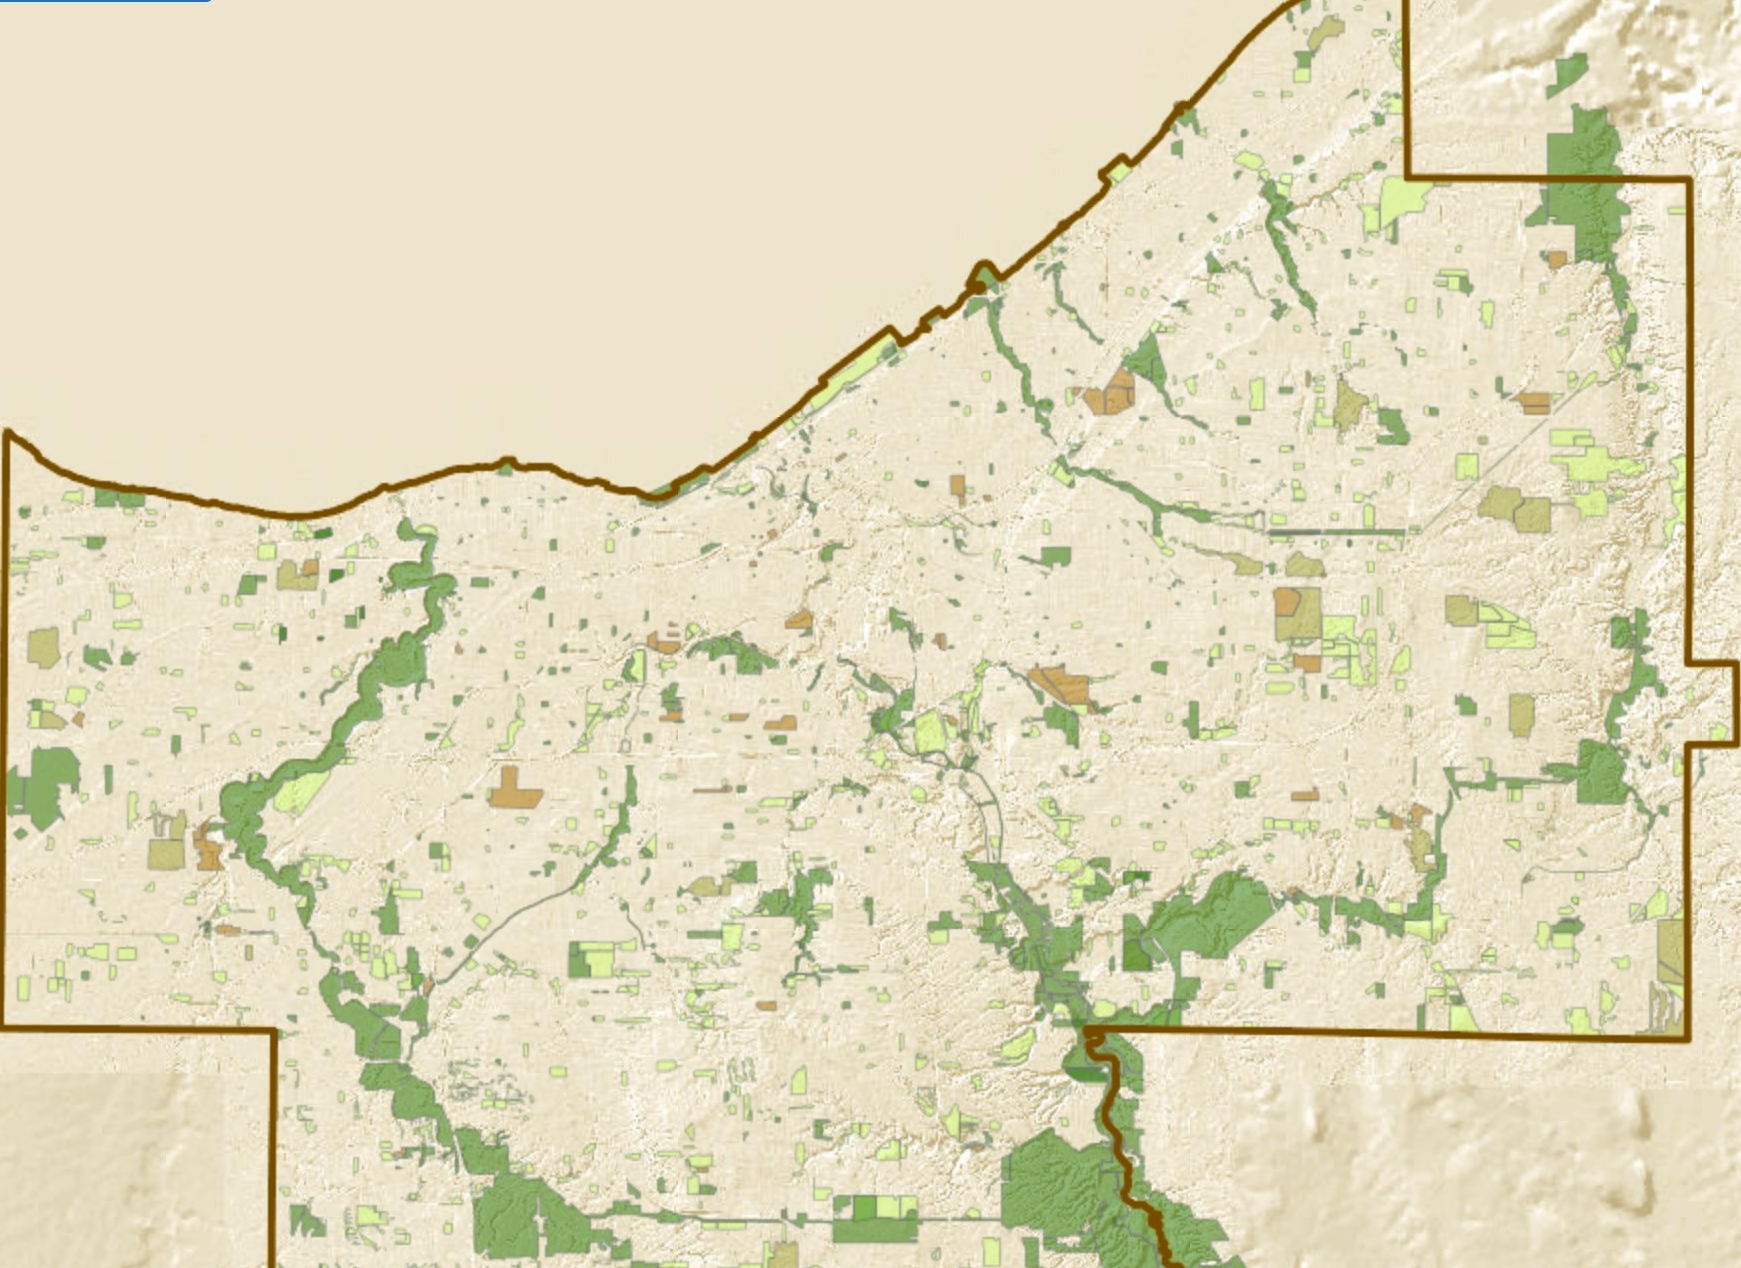

In [87]:
# First, open map of tree canopy metrics
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\Cuyahoga_County_treecanopy.png")

I created an excel sheet converted to csv file that contains 21 cells of blocks of tree canopy census tracts from this map. Looking deeper at the map, the majority of existing tree canopy are in parks/reservations. 

In [88]:
df_tree_canopy_cle_6yr = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\cle_treecanopy6yr.csv')

In [89]:
df_tree_canopy_cle_6yr.head()

GEOID10   NAME10            NAMELSAD10  Tree_Canopy_2011_Area  \
0  39035107802  1078.02  Census Tract 1078.02            1010948.765   
1  39035107101  1071.01  Census Tract 1071.01            1617285.132   
2  39035101200  1012.00     Census Tract 1012            2690815.824   
3  39035107701  1077.01  Census Tract 1077.01            1048759.186   
4  39035104200  1042.00     Census Tract 1042            1580342.113   

   Tree_Canopy_2017_Area  Tree_Canopy_percent_2011  Tree_Canopy_percent_2017  
0           9.205252e+05                    6.0514                    5.5102  
1           1.745303e+06                    3.5415                    3.8218  
2           2.083200e+06                   18.6969                   14.4750  
3           1.007621e+06                    4.8895                    4.6977  
4           1.488815e+06                    9.8956                    9.3225

In [90]:
df_tree_canopy_cle_6yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GEOID10                   20 non-null     int64  
 1   NAME10                    20 non-null     float64
 2   NAMELSAD10                20 non-null     object 
 3   Tree_Canopy_2011_Area     20 non-null     float64
 4   Tree_Canopy_2017_Area     20 non-null     float64
 5   Tree_Canopy_percent_2011  20 non-null     float64
 6   Tree_Canopy_percent_2017  20 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ KB


In [91]:
df_tree_canopy_cle_6yr["GEOID10"] = df_tree_canopy_cle_6yr["GEOID10"].astype(str)
print(df_tree_canopy_cle_6yr.dtypes)

GEOID10                      object
NAME10                      float64
NAMELSAD10                   object
Tree_Canopy_2011_Area       float64
Tree_Canopy_2017_Area       float64
Tree_Canopy_percent_2011    float64
Tree_Canopy_percent_2017    float64
dtype: object


In [92]:
# Sample from two different normal distributions
means = 10, 20
stdevs = 4, 2
dist = pd.DataFrame(
    np.random.normal(loc=means, scale=stdevs, size=(1000, 2)),
    columns=['Tree_Canopy_percent_2011', 'Tree_Canopy_percent_2017'])
dist.agg(['min', 'max', 'mean', 'std']).round(decimals=2)

Tree_Canopy_percent_2011  Tree_Canopy_percent_2017
min                      -2.65                     13.85
max                      21.87                     27.28
mean                     10.09                     19.94
std                       3.95                      2.01

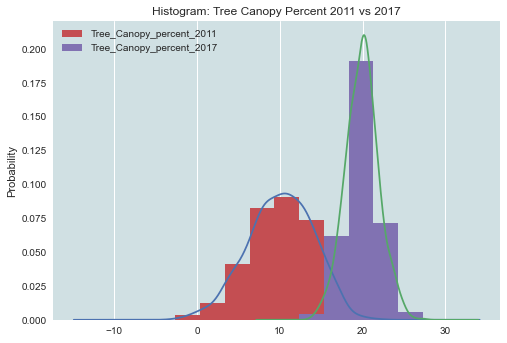

In [93]:
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False, title='Histogram: Tree Canopy Percent 2011 vs 2017')
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d0e0e3')

In [109]:
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

SyntaxError: invalid syntax (<ipython-input-109-d3bfc748244a>, line 1)

In [110]:
#

In [106]:
print(type(df))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [104]:
#

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(data1, bins=100, alpha=0.5, label="data1")
plt.hist(data2, bins=100, alpha=0.5, label="data2")